# Approach

* This is a simplied version of YOLO. We take our 512x512 input, divide it into a 16x16 grid, each cell outputs five values:
    * The confidence that there is pneumonia present
    * The x, y, w, and h of the bounding box
* For labels we have assigned each box to the cell which is in it's center and have assigned the actual x, y, w, and h values to that cell.

# Network

* The network consists of a number of residual blocks with convolutions and downsampling blocks with max pooling.
* The network outputs a 16x16x1 array of confidences and a 16x16x4 array of bounding boxes.
* The confidence cells have a sigmoid activation, the bboxes are linear.
* We use a binary cross entropy loss for the confidence and mean squared error for the bounding boxes.

# Predictions
* To generate our predictions we loop through each cell of the output, if the confidence is greater than 0.5 we append the corresponding bounding box to the prediction string. 

**Note:** Since each pixel only outputs one bounding box there is currently no non-max suppression. We can add this later if neccessary.

**Change Log:**
* v3 - changing output to 8x8 grid from 16x16; changed model to downsample one more time; adjusted network accordingly. 
* v4 - changed output to 4x4 grid, no image has more than 3 ROIs so this may work better? 
    * Using center point of ROI to predict instead of upper left corner.
* v5 - We only calculate MSE loss for boxes with a confidence over 0.5 or actual truth since we don't care about predictions for boxes that are not ROIs. This will prevent the network from being constrained by outputting 0s for boxes that don't exist.

In [1]:
import os
import csv
import random
import pydicom
import numpy as np
import pickle
import pandas as pd
from skimage import measure
from skimage.transform import resize
import datetime
import math

import tensorflow as tf
from tensorflow import keras

from matplotlib import pyplot as plt
import matplotlib.patches as patches

In [2]:
# Malisiewicz et al.
def non_max_suppression_fast(boxes, overlapThresh=0.3):
    # if there are no boxes, return an empty list
    if len(boxes) == 0:
        return []
 
    # if the bounding boxes integers, convert them to floats --
    # this is important since we'll be doing a bunch of divisions
    if boxes.dtype.kind == "i":
        boxes = boxes.astype("float")
 
    # initialize the list of picked indexes	
    pick = []
 
    # grab the coordinates of the bounding boxes
    x1 = boxes[:,0]
    y1 = boxes[:,1]
    w = boxes[:,2]
    h = boxes[:,3]
 
    x2 = x1 + w
    y2 = y1 + h

    # compute the area of the bounding boxes and sort the bounding
    # boxes by the bottom-right y-coordinate of the bounding box
    area = (w + 1) * (h + 1)
    idxs = np.argsort(y2)
 
    # keep looping while some indexes still remain in the indexes
    # list
    while len(idxs) > 0:
        # grab the last index in the indexes list and add the
        # index value to the list of picked indexes
        last = len(idxs) - 1
        i = idxs[last]
        pick.append(i)
 
        # find the largest (x, y) coordinates for the start of
        # the bounding box and the smallest (x, y) coordinates
        # for the end of the bounding box
        xx1 = np.maximum(x1[i], x1[idxs[:last]])
        yy1 = np.maximum(y1[i], y1[idxs[:last]])
        xx2 = np.minimum(x2[i], x2[idxs[:last]])
        yy2 = np.minimum(y2[i], y2[idxs[:last]])
 
        # compute the width and height of the bounding box
        w = np.maximum(0, xx2 - xx1 + 1)
        h = np.maximum(0, yy2 - yy1 + 1)
 
        # compute the ratio of overlap
        overlap = (w * h) / area[idxs[:last]]
 
        # delete all indexes from the index list that have
        idxs = np.delete(idxs, np.concatenate(([last],
            np.where(overlap > overlapThresh)[0])))
 
    # return only the bounding boxes that were picked using the
    # integer data type
    return boxes[pick].astype("int")

In [3]:
# enter your Kaggle credentionals here
os.environ['KAGGLE_USERNAME']="skooch"
os.environ['KAGGLE_KEY']="42f8a02ee92cc773d1dbe66565673ad3"

In [4]:
def sigmoid(x):
    return 1 / (1 + math.exp(-x))

# Load pneumonia locations

Table contains [filename : pneumonia location] pairs per row. 
* If a filename contains multiple pneumonia, the table contains multiple rows with the same filename but different pneumonia locations. 
* If a filename contains no pneumonia it contains a single row with an empty pneumonia location.

The code below loads the table and transforms it into a dictionary. 
* The dictionary uses the filename as key and a list of pneumonia locations in that filename as value. 
* If a filename is not present in the dictionary it means that it contains no pneumonia.

In [5]:
ROOT_DIR = "./"

train_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_train_images')
test_dicom_dir = os.path.join(ROOT_DIR, 'stage_1_test_images')
print("Train dir:", train_dicom_dir)

Train dir: ./stage_1_train_images


In [6]:
with open('yolo_labels_center_4x4.p', 'rb') as handle:
    pneumonia_locations = pickle.load(handle)

# Load filenames

In [7]:
random.seed(72)

# load and shuffle filenames
folder = './stage_1_train_images'
filenames = os.listdir(folder)
random.shuffle(filenames)
# split into train and validation filenames
n_valid_samples = int(len(filenames) * 0.1)
train_filenames = filenames[n_valid_samples:]
valid_filenames = filenames[:n_valid_samples]
print('n train samples', len(train_filenames))
print('n valid samples', len(valid_filenames))
n_train_samples = len(filenames) - n_valid_samples

n train samples 23116
n valid samples 2568


 # Data generator

The dataset is too large to fit into memory, so we need to create a generator that loads data on the fly.

* The generator takes in some filenames, batch_size and other parameters.

* The generator outputs a random batch of numpy images and numpy masks.
    

In [8]:
BATCH_SIZE = 16
IMAGE_SIZE = 512
CHECKPOINT_PATH = "yolo5_512.h5"

In [9]:
class generator(keras.utils.Sequence):
    
    def __init__(self, folder, filenames, pneumonia_locations=None, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=False, predict=False):
        self.folder = folder
        self.filenames = filenames
        self.pneumonia_locations = pneumonia_locations
        self.batch_size = batch_size
        self.image_size = image_size
        self.shuffle = shuffle
        self.augment = augment
        self.predict = predict
        self.on_epoch_end()
        
    def __load__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # get filename without extension
        filename = filename.split('.')[0]
        label = pneumonia_locations[filename].copy()
        
        # remove the confidence and bboxes
        confs = label[:,:,0]
        boxes = label[:,:,1:]
        
        ## data augmentation may be complicated, let's do that later
        # if augment then horizontal flip half the time
        if self.augment and random.random() > 0.5:
            # flip the image
            img = np.fliplr(img)
            
            # update our x coords - any cell that has a positive x coordinate should be subtracted from 1024
            mask = confs > 0
            boxes[mask, 0] = 1024 - boxes[mask,0]
            
            # flip our boxes lr on axis 0
            boxes = np.flip(boxes, axis=0)         
            
            # flip the confidences lr as well
            confs = np.flip(confs, axis=0)
            
        # resize both image and mask
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        
        boxes = np.concatenate([confs.reshape((4,4,1)), boxes], axis=2)
        
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img, confs, boxes
    
    def __loadpredict__(self, filename):
        # load dicom file as numpy array
        img = pydicom.dcmread(os.path.join(self.folder, filename)).pixel_array
        # resize image
        img = resize(img, (self.image_size, self.image_size), mode='reflect')
        # add trailing channel dimension
        img = np.expand_dims(img, -1)
        return img
        
    def __getitem__(self, index):
        # select batch
        filenames = self.filenames[index*self.batch_size:(index+1)*self.batch_size]
        # predict mode: return images and filenames
        if self.predict:
            # load files
            imgs = [self.__loadpredict__(filename) for filename in filenames]
            # create numpy batch
            imgs = np.array(imgs)
            return imgs, filenames
        # train mode: return images and masks
        else:
            # load files
            items = [self.__load__(filename) for filename in filenames]
            
            # unzip images and masks
            imgs, confs, bboxes = zip(*items)
            
            # create numpy batch
            imgs = np.array(imgs)
            confs = np.expand_dims(np.array(confs), -1)
            bboxes = np.array(bboxes)
            
            labels = {"confidence_output": confs, "bboxes_output": bboxes}
            return imgs, labels
        
    def on_epoch_end(self):
        if self.shuffle:
            random.shuffle(self.filenames)
        
    def __len__(self):
        if self.predict:
            # return everything
            return int(np.ceil(len(self.filenames) / self.batch_size))
        else:
            # return full batches only
            return int(len(self.filenames) / self.batch_size)

# Network

In [22]:
def create_downsample(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.MaxPool2D(2)(x)
    return x

def create_resblock(channels, inputs):
    x = keras.layers.BatchNormalization(momentum=0.9)(inputs)
    x = keras.layers.LeakyReLU(0)(x)
    x_1 = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_1)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.add([x, x_1])
    return x

def create_network(input_size, channels, n_blocks=2, depth=4):
    # input - 512x512x3
    inputs = keras.Input(shape=(input_size, input_size, 1))
    
    # 256x256x24
    x = keras.layers.Conv2D(channels, 3, strides=(2,2), padding='same', use_bias=False)(inputs)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    x = keras.layers.Conv2D(channels, 3, padding='same', use_bias=False)(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # 256x256x24 for residual connection
    x = keras.layers.Conv2D(channels, 1, padding='same', use_bias=False)(x)
    
    # residual blocks
    for d in range(depth):
        channels = channels * 2
        
        x = create_downsample(channels, x)
            
        for b in range(n_blocks):
            x = create_resblock(channels, x)
    
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0)(x)
    
    # dilated convolutions for context - 16x16x512
    x_2 = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x_2)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    x = keras.layers.Conv2D(512, (3,3), padding='same', dilation_rate=(2,2), activation=None, name="dilated_conv_2")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    # downsample to 8x8x512 with stride 2
    x = keras.layers.Conv2D(512, (3,3), padding='same', strides=(2,2), activation=None, name="downsample_1")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    # one more 3x3 conv to consolidate - 8x8x512
    x = keras.layers.Conv2D(512, (3,3), padding='same', activation=None, name="last_conv")(x)
    x = keras.layers.BatchNormalization(momentum=0.9)(x)
    x = keras.layers.LeakyReLU(0.01)(x)
    
    # downsample to 4x4x512
    x = keras.layers.MaxPool2D(2)(x)
    
    # confidence branch
    c = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_1_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(x)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.25)(c)
    
    c = keras.layers.Conv2D(512, (1,1), padding='same', activation=None, name="fc_2_c", kernel_regularizer=keras.regularizers.l2(l=0.01))(c)
    c = keras.layers.BatchNormalization(momentum=0.9)(c)
    c = keras.layers.LeakyReLU(0.01)(c)
    c = keras.layers.Dropout(0.25)(c)
    
    confidence = keras.layers.Conv2D(1, (1,1), padding='same', activation=None, name="confidence_output")(c)
    
    # bounding box branch
    b = keras.layers.Conv2D(1024, (1,1), padding='same', activation=None, name="fc_1_b", kernel_regularizer=keras.regularizers.l2(l=0.001))(x)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.20)(b)
    
    b = keras.layers.Conv2D(768, (1,1), padding='same', activation=None, name="fc_2_b")(b)
    b = keras.layers.BatchNormalization(momentum=0.9)(b)
    b = keras.layers.LeakyReLU(0.01)(b)
    b = keras.layers.Dropout(0.10)(b)
    
    b = keras.layers.Conv2D(4, (1,1), padding='same', activation="linear")(b)
    boxes = keras.layers.concatenate([confidence, b], name="bboxes_output")
    
    # return both outputs
    model = keras.Model(inputs=inputs, outputs=[confidence, boxes])
    
    return model

# Train network


In [23]:
# define iou or jaccard loss function
def iou_loss(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    intersection = tf.reduce_sum(y_true * y_pred)
    score = (intersection + 1.) / (tf.reduce_sum(y_true) + tf.reduce_sum(y_pred) - intersection + 1.)
    return 1 - score

# combine bce loss and iou loss
def iou_bce_loss(y_true, y_pred):
    return 0.4 * keras.losses.binary_crossentropy(y_true, y_pred) + 0.6 * iou_loss(y_true, y_pred)

# mean iou as a metric
def mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    mean_iou = tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))
    return mean_iou

def adj_mean_iou(y_true, y_pred):
    y_pred = tf.round(y_pred)
    y_true_pos = tf.reduce_max(y_true, axis=[1, 2, 3])
    
    intersect = tf.reduce_sum(y_true * y_pred, axis=[1, 2, 3])
    union = tf.reduce_sum(y_true, axis=[1, 2, 3]) + tf.reduce_sum(y_pred, axis=[1, 2, 3])
    smooth = tf.ones(tf.shape(intersect))
    
    return tf.reduce_mean((intersect + smooth) / (union - intersect + smooth))

def binary_accuracy(y_true, y_pred):
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.round(tf.sigmoid(tf.reshape(y_pred, [-1])))
    
    acc = tf.reduce_mean(tf.cast(tf.equal(y_true, y_pred), dtype=tf.float32))
    return acc

def weighted_binary_cross_entropy(y_true, y_pred):
    weight = 40
    y_true = tf.reshape(y_true, [-1])
    y_pred = tf.reshape(y_pred, [-1])
    weights = tf.multiply(tf.cast(weight, tf.float32), tf.cast(tf.greater(y_true, 0), tf.float32)) + 1
    xe = tf.losses.sigmoid_cross_entropy(multi_class_labels=y_true, logits=y_pred, weights=weights)
    
    return xe
    
def overlap_iou(y_true, y_pred):
    """
    Args:
        bboxes1: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        bboxes2: shape (batch_size, 16, 16, 4)
            with x1, y1, x2, y2 point order.
        p1 *-----
           |     |
           |_____* p2
    Returns:
        Tensor with shape (total_bboxes1, total_bboxes2)
        with the IoU (intersection over union) of bboxes1[i] and bboxes2[j]
        in [i, j].
    """
    # flatten the data because it's easier that way
    bboxes1 = tf.reshape(y_true, (-1, 5))
    bboxes2 = tf.reshape(y_pred, (-1, 5))
    
    # split the components out
    true_boxes, x11, y11, w1, h1 = tf.split(bboxes1, 5, axis=1)
    pred_conf, x21, y21, w2, h2 = tf.split(bboxes2, 5, axis=1)
    
    # is a box predicted here? maybe use this for the IOU?
    pred_conf = tf.sigmoid(pred_conf)
    mask = (pred_conf >= 0.5) | (true_boxes == 1)
    
    # these labels are center points of the boxes so we need to calculate the corners
    x12 = x11 + (w1 / 2)
    y12 = y11 + (h1 / 2)
    x22 = x21 + (w2 / 2)
    y22 = y21 + (h2 / 2)
    
    x11 = x11 - (w1 / 2)
    y11 = y11 - (h1 / 2)
    x21 = x21 - (w2 / 2)
    y21 = y21 - (h2 / 2)

    # find the corners of the intersection area
    xI1 = tf.maximum(x11, x21)
    yI1 = tf.maximum(y11, y21)

    xI2 = tf.minimum(x12, x22)
    yI2 = tf.minimum(y12, y22)
    
    # get the intersection area, if the truth has no boxes it is 0
    inter_area = true_boxes * (xI2 - xI1 + 1) * (yI2 - yI1 + 1)

    # get the area of each box
    bboxes1_area = (w1 + 1) * (h1 + 1)
    bboxes2_area = (w2 + 1) * (h2 + 1)
    
    # union is area of both boxes - intersection
    union = (bboxes1_area + bboxes2_area) - inter_area + 1
    
    # reduce the mean so we have mean iou for our inputs
    return tf.reduce_mean(tf.maximum(inter_area / union, 0))

# only apply mse to layers with high confidence that there is an ROI
def adj_mse(y_true, y_pred):
    # separate the confidence from the boxes
    conf_pred = y_pred[:,:,:,0]
    box_pred = y_pred[:,:,:,1:]
    
    conf_true = y_true[:,:,:,0]
    box_true = y_true[:,:,:,1:]
    
    # apply the sigmoid to the predicted confidence
    conf_sigmoid = tf.sigmoid(conf_pred)
    
    # only get loss for boxes which are predicted positive OR are actually positive
    mask = (conf_sigmoid > 0.5) | (conf_true == 1)
    
    # get the MSE
    diff = box_true - box_pred
    diff = tf.square(diff)
    diff = tf.reduce_mean(diff, axis=0)
    
    # apply the mask
    mse = tf.boolean_mask(diff, mask)
    
    # reduce the mean
    mse = tf.reduce_mean(mse)
    
    return mse
    

# create network and compiler
model = create_network(input_size=IMAGE_SIZE, channels=24, n_blocks=1, depth=4)

losses = {
    "confidence_output": weighted_binary_cross_entropy,
    "bboxes_output": adj_mse,
}
lossWeights = { "confidence_output": 7.5, "bboxes_output": 0.5 }

metrics_dict = {
    "confidence_output": binary_accuracy,
    "bboxes_output": [overlap_iou],
}

model.compile(optimizer='adam',
              loss=losses,
              loss_weights=lossWeights,
              metrics=metrics_dict)

# cosine learning rate annealing
def exp_decay(x):
    lr0 = 0.01
    epochs_drop = 5
    drop = 0.75
    lrate = lr0 * math.pow(drop, math.floor((1+x)/epochs_drop))
    return lrate

learning_rate = tf.keras.callbacks.LearningRateScheduler(exp_decay)
checkpoint = keras.callbacks.ModelCheckpoint(CHECKPOINT_PATH, monitor='val_loss', verbose=1, save_best_only=False, save_weights_only=True, mode='auto', period=1)

# create train and validation generators
folder = './stage_1_train_images'
train_gen = generator(folder, train_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=True, augment=True, predict=False)
valid_gen = generator(folder, valid_filenames, pneumonia_locations, batch_size=BATCH_SIZE, image_size=IMAGE_SIZE, shuffle=False, predict=False)

print(model.summary())

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            (None, 512, 512, 1)  0                                            
__________________________________________________________________________________________________
conv2d_43 (Conv2D)              (None, 256, 256, 24) 216         input_3[0][0]                    
__________________________________________________________________________________________________
batch_normalization_65 (BatchNo (None, 256, 256, 24) 96          conv2d_43[0][0]                  
__________________________________________________________________________________________________
leaky_re_lu_65 (LeakyReLU)      (None, 256, 256, 24) 0           batch_normalization_65[0][0]     
__________________________________________________________________________________________________
conv2d_44 

In [24]:
model.load_weights(CHECKPOINT_PATH)

In [27]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=10, shuffle=True, verbose=1, initial_epoch=5)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 6/10
1443/1444 [============================>.] - ETA: 0s - loss: 142.5912 - confidence_output_loss: 1.5870 - bboxes_output_loss: 239.5396 - confidence_output_binary_accuracy: 0.5457 - bboxes_output_overlap_iou: 0.0022
Epoch 00006: saving model to yolo5_512.h5
1444/1444 [==============================] - 942s 652ms/step - loss: 142.6147 - confidence_output_loss: 1.5873 - bboxes_output_loss: 239.5863 - confidence_output_binary_accuracy: 0.5457 - bboxes_output_overlap_iou: 0.0022 - val_loss: 117.8789 - val_confidence_output_loss: 1.3515 - val_bboxes_output_loss: 201.0148 - val_confidence_output_binary_accuracy: 0.6433 - val_bboxes_output_overlap_iou: 0.0024
Epoch 7/10
1443/1444 [============================>.] - ETA: 0s - loss: 137.5811 - confidence_output_loss: 1.4260 - bboxes_output_loss: 238.5025 - confidence_output_binary_accuracy: 0.5899 - bboxes_output_overlap_iou: 0.0022
Epoch 00007: saving model to yolo5_512.h5
1444/1444 [==============================] - 895s 620ms/step - 

In [30]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=15, shuffle=True, verbose=1, initial_epoch=10)

Epoch 11/15


/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


1443/1444 [============================>.] - ETA: 0s - loss: 129.8888 - confidence_output_loss: 1.3232 - bboxes_output_loss: 229.2811 - confidence_output_binary_accuracy: 0.6358 - bboxes_output_overlap_iou: 0.0022
Epoch 00011: saving model to yolo5_512.h5
1444/1444 [==============================] - 874s 606ms/step - loss: 130.0218 - confidence_output_loss: 1.3235 - bboxes_output_loss: 229.5419 - confidence_output_binary_accuracy: 0.6358 - bboxes_output_overlap_iou: 0.0022 - val_loss: 122.3783 - val_confidence_output_loss: 1.1589 - val_bboxes_output_loss: 219.4899 - val_confidence_output_binary_accuracy: 0.6938 - val_bboxes_output_overlap_iou: 0.0023
Epoch 12/15
1443/1444 [============================>.] - ETA: 0s - loss: 126.6458 - confidence_output_loss: 1.2806 - bboxes_output_loss: 223.5509 - confidence_output_binary_accuracy: 0.6555 - bboxes_output_overlap_iou: 0.0022
Epoch 00012: saving model to yolo5_512.h5
1444/1444 [==============================] - 889s 615ms/step - loss: 126.

KeyboardInterrupt: 

In [13]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=25, shuffle=True, verbose=1, initial_epoch=14)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 15/25
1443/1444 [============================>.] - ETA: 1s - loss: 115.4446 - confidence_output_loss: 1.1703 - bboxes_output_loss: 205.7136 - confidence_output_binary_accuracy: 0.6859 - bboxes_output_overlap_iou: 0.0027
Epoch 00015: saving model to yolo5_512.h5
1444/1444 [==============================] - 1865s 1s/step - loss: 115.3802 - confidence_output_loss: 1.1701 - bboxes_output_loss: 205.5898 - confidence_output_binary_accuracy: 0.6860 - bboxes_output_overlap_iou: 0.0027 - val_loss: 109.0550 - val_confidence_output_loss: 1.0070 - val_bboxes_output_loss: 196.3384 - val_confidence_output_binary_accuracy: 0.7317 - val_bboxes_output_overlap_iou: 0.0032
Epoch 16/25
1443/1444 [============================>.] - ETA: 0s - loss: 114.3800 - confidence_output_loss: 1.1512 - bboxes_output_loss: 203.9916 - confidence_output_binary_accuracy: 0.6916 - bboxes_output_overlap_iou: 0.0028
Epoch 00016: saving model to yolo5_512.h5
1444/1444 [==============================] - 895s 620ms/step - 

In [ ]:
history = model.fit_generator(train_gen, validation_data=valid_gen, callbacks=[learning_rate, checkpoint], epochs=35, shuffle=True, verbose=1, initial_epoch=26)

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Epoch 26/35
1443/1444 [============================>.] - ETA: 0s - loss: 104.2846 - confidence_output_loss: 1.0448 - bboxes_output_loss: 191.7772 - confidence_output_binary_accuracy: 0.7300 - bboxes_output_overlap_iou: 0.0034
Epoch 00026: saving model to yolo5_512.h5
1444/1444 [==============================] - 908s 629ms/step - loss: 104.3329 - confidence_output_loss: 1.0448 - bboxes_output_loss: 191.8744 - confidence_output_binary_accuracy: 0.7300 - bboxes_output_overlap_iou: 0.0034 - val_loss: 97.7383 - val_confidence_output_loss: 0.9760 - val_bboxes_output_loss: 179.7452 - val_confidence_output_binary_accuracy: 0.7104 - val_bboxes_output_overlap_iou: 0.0038
Epoch 27/35
 262/1444 [====>.........................] - ETA: 11:11 - loss: 109.3017 - confidence_output_loss: 1.0787 - bboxes_output_loss: 201.3024 - confidence_output_binary_accuracy: 0.7229 - bboxes_output_overlap_iou: 0.0035

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


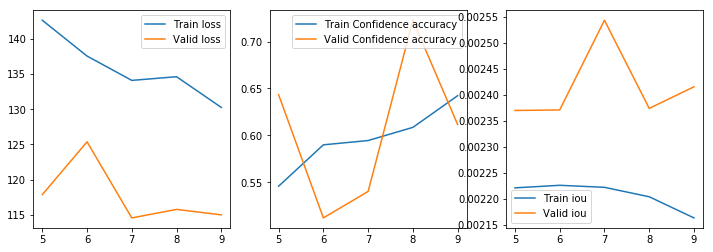

In [28]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

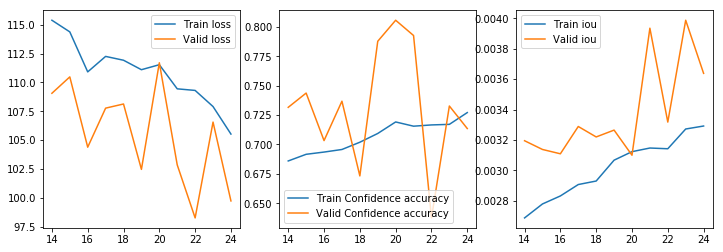

In [15]:
plt.figure(figsize=(12,4))
plt.subplot(131)
plt.plot(history.epoch, history.history["loss"], label="Train loss")
plt.plot(history.epoch, history.history["val_loss"], label="Valid loss")
plt.legend()
plt.subplot(132)
plt.plot(history.epoch, history.history["confidence_output_binary_accuracy"], label="Train Confidence accuracy")
plt.plot(history.epoch, history.history["val_confidence_output_binary_accuracy"], label="Valid Confidence accuracy")
plt.legend()
plt.subplot(133)
plt.plot(history.epoch, history.history["bboxes_output_overlap_iou"], label="Train iou")
plt.plot(history.epoch, history.history["val_bboxes_output_overlap_iou"], label="Valid iou")
plt.legend()
plt.show()

## Sample Predictions

/home/eric/.local/lib/python3.5/site-packages/skimage/transform/_warps.py:110: UserWarning: Anti-aliasing will be enabled by default in skimage 0.15 to avoid aliasing artifacts when down-sampling images.
  warn("Anti-aliasing will be enabled by default in skimage 0.15 to "


Max: 0.8131283711216708
281 200 227 335
277 199 226 335
277 200 227 336
281 199 226 335


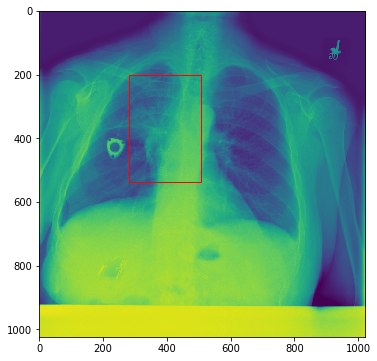

Max: 0.8399629333125098
282 210 226 332
277 205 227 335
281 199 227 336
279 198 227 336
280 199 227 337


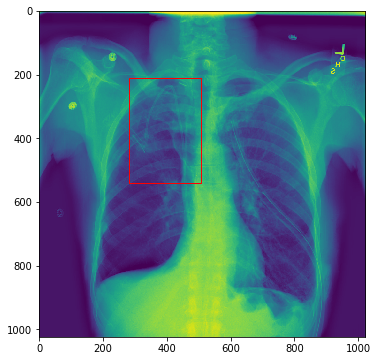

Max: 0.3905601207443172


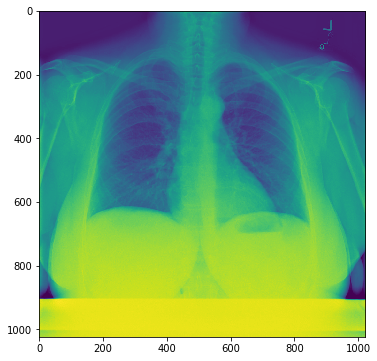

Max: 0.9924162693854975
279 198 227 336
283 201 227 338
265 205 227 354
321 204 230 352
283 205 227 334
260 261 224 330
382 283 232 355


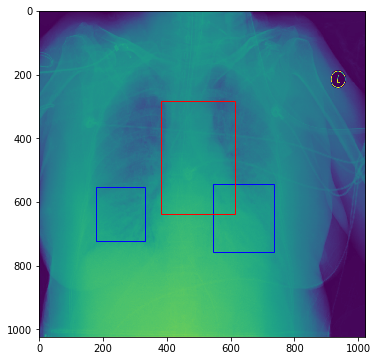

Max: 0.7738200798420063
279 201 227 335
277 203 226 334
280 200 227 337


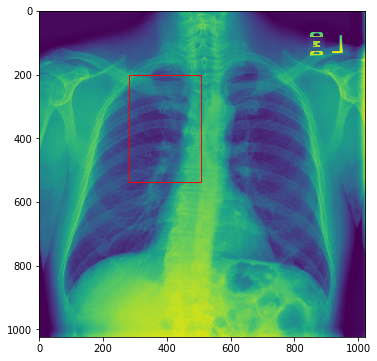

Max: 0.9399061725872349
272 209 225 330
282 199 226 334
277 222 224 322
299 217 225 327


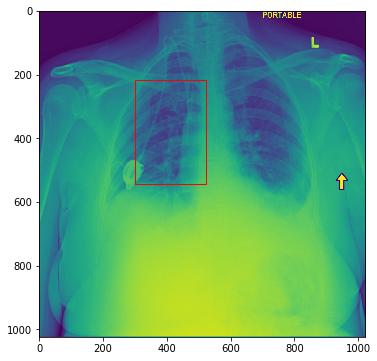

Max: 0.8570258390830012
279 199 228 342
276 200 226 336
279 199 227 335
286 201 228 338
283 201 227 337
276 209 226 331
280 202 227 335


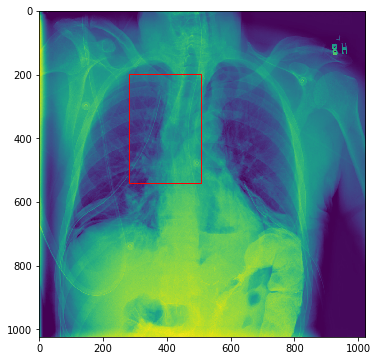

Max: 0.47940003868423203


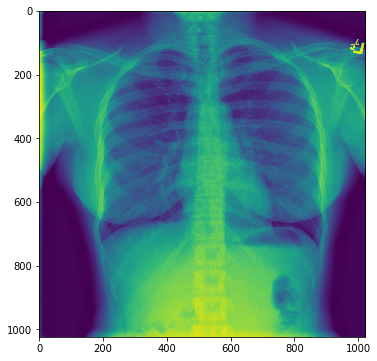

In [18]:
THRESHOLD = 0.5
OVERLAP = 0.3
# look at some sample predictions
samples = np.random.choice(train_filenames, size=8, replace=False)

for filename in samples:
    # load the image
    img = pydicom.dcmread(os.path.join(train_dicom_dir, filename)).pixel_array
    
    filename = filename.split('.')[0]
    
    f, ax = plt.subplots(figsize=(6, 6))
    plt.imshow(img)
    # get boxes for the truth
    if filename in pneumonia_locations:
        locs = pneumonia_locations[filename]
        for i in range(4):
            for j in range(4):
                pixel_data = locs[i,j,:]
                if pixel_data[0] > 0:
                    x, y, w, h = pixel_data[1:]
                    x = int(x)
                    y = int(y)
                    w = int(w)
                    h = int(h)
                    
                    x = x - (w // 2)
                    y = y - (h // 2)
                    
                    rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='b',facecolor='none')
                    ax.add_patch(rect)
    
    # predict the image
    img = resize(img, (IMAGE_SIZE, IMAGE_SIZE), mode='reflect')
    yhat = model.predict(img.reshape(1, IMAGE_SIZE, IMAGE_SIZE, 1))
    
    conf = np.squeeze(yhat[0])
    bboxes = np.squeeze(yhat[1])
    boxes = []
    
    print("Max:", sigmoid(np.max(conf)))
    # loop through our predictions
    for i in range(4):
        for j in range(4):
            conf_ = sigmoid(conf[i, j])
            # if we have a prediction
            if conf_ > THRESHOLD:
                _, x,y,w,h = bboxes[i,j,:]
                x = int(x)
                y = int(y)
                w = int(w)
                h = int(h)
                
                # convert to upper left corner from center
                x = x - (w // 2)
                y = y - (h // 2)
                
                # if the boxes have width and height
                if w > 10 and h > 10:
                    print(x,y,w,h)
                    boxes.append([x,y,w,h])
    
    # do non-max suppression of our boxes
    boxes = non_max_suppression_fast(np.array(boxes), OVERLAP)
    
    # plot our boxes
    for box in boxes:
        w,y,w,h = box
        rect = patches.Rectangle((x,y),w,h,linewidth=1,edgecolor='r',facecolor='none')
        ax.add_patch(rect)

    plt.show()

# Predict test images

In [ ]:
THRESHOLD = 0.5

# load and shuffle filenames
folder = './stage_1_test_images'
test_filenames = os.listdir(folder)
print('n test samples:', len(test_filenames))

# create test generator with predict flag set to True
test_gen = generator(folder, test_filenames, None, batch_size=3, image_size=IMAGE_SIZE, shuffle=False, predict=True)

# create submission dictionary
submission_dict = {}
# loop through testset
for imgs, filenames in test_gen:
    
    # predict batch of images
    conf_preds, bbox_preds = model.predict(imgs)
    
    # loop through batch
    for confs, bboxes, filename in zip(conf_preds, bbox_preds, filenames):
        predictionString = ""
        print(filename)
        boxes = []
        for i in range(4):
            for j in range(4):
                conf = sigmoid(confs[i, j, 0])
                if conf > THRESHOLD:
                    x, y, w, h = bboxes[i,j]
                    
                    # possible thresholds to keep our boxes within reasonable sizes?
                    if True: #w < 600 and h < 1000:
                        # cast to ints
                        x = int(x)
                        y = int(y)
                        w = int(w)
                        h = int(h)
                        
                        # convert to upper left corner from center
                        x = x - (w // 2)
                        y = y - (h // 2)
                        
                        if w > 20 and h > 20:
                            # make sure our boxes don't run off the edges of the images
                            w = np.minimum(w, 1024 - x)
                            h = np.minimum(h, 1024 - y)
                            boxes.append([x,y,w,h])

        # do our non-max suppression here
        boxes = non_max_suppression_fast(np.array(boxes), 0.3)
        
        # loop through our suppressed boxes and creat the prediction string
        for box in boxes:
            x,y,w,h = box
            # create the prediction string
            predictionString += str(conf) + ' ' + str(x) + ' ' + str(y) + ' ' + str(w) + ' ' + str(h) + ' '
            
        # add filename and predictionString to dictionary
        filename = filename.split('.')[0]
        submission_dict[filename] = predictionString

    # stop if we've got them all
    if len(submission_dict) >= len(test_filenames):
        break
    break
    
# save dictionary as csv file
sub = pd.DataFrame.from_dict(submission_dict,orient='index')
sub.index.names = ['patientId']
sub.columns = ['PredictionString']

now = datetime.datetime.now()
today = str(now)[:10]
submission_file = today + "_yolo_submission.csv" 
sub.to_csv(submission_file)

In [19]:
!kaggle competitions submit -c rsna-pneumonia-detection-challenge -f submission.csv -m "YOLOv2 512x512 10 epochs"

Successfully submitted to RSNA Pneumonia Detection Challenge

In [20]:
save_file_to_drive("submission.csv", "submission.csv")
save_file_to_drive(CHECKPOINT_PATH, CHECKPOINT_PATH)

File ID: 1GGJOHEa4uJTtlo-cvF2NLYjCbKp6hq3_
File ID: 1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ


{'id': '1C7SXJVn51_rnrx8bU_1v8k-zeFhHybkJ'}

In [21]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}
!gsutil cp ./{CHECKPOINT_PATH} gs://{bucket_name}/

Updated property [core/project].
Copying file://./model7_448.h5 [Content-Type=application/octet-stream]...
|
Operation completed over 1 objects/93.8 MiB.                                     


In [19]:
# upload checkpoint to GCS
project_id = 'mammography-198911'
bucket_name = 'pneumonia'

!gcloud config set project {project_id}

Updated property [core/project].


In [20]:
!gsutil cp ./yolo_labels.p gs://{bucket_name}/

Copying file://./yolo_labels.p [Content-Type=text/x-pascal]...
==> NOTE: You are uploading one or more large file(s), which would run
significantly faster if you enable parallel composite uploads. This
feature can be enabled by editing the
"parallel_composite_upload_threshold" value in your .boto
configuration file. However, note that if you do this large files will
be uploaded as `composite objects
<https://cloud.google.com/storage/docs/composite-objects>`_,which
means that any user who downloads such objects will need to have a
compiled crcmod installed (see "gsutil help crcmod"). This is because
without a compiled crcmod, computing checksums on composite objects is
so slow that gsutil disables downloads of composite objects.

ResumableUploadAbortException: 403 Insufficient Permission
